In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
proj_dir = Path("../..")

In [3]:
mcn_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_MCN.csv")
prd_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_PRD.csv")
wan_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_WAN.csv")
ris_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_RIS.csv")
pro_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_PRO.csv")
ihr_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_IHR.csv")
lmn_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_LMN.csv")
lgs_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_LGS.csv")
lwg_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_LWG.csv")
jda_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_JDA.csv")

In [4]:
run_schedules = {
    "mcnary": {
        "spring": ["04-01", "06-08"],
        "summer": ["06-09", "08-08"],
        "fall": ["08-09", "10-31"],
    },
    "priest_rapids": {
        "spring": ["04-15", "06-13"],
        "summer": ["06-14", "08-13"],
        "fall": ["08-14", "11-15"],
    },
    "prosser": {"spring": ["03-01", "08-15"], "fall": ["08-16", "12-15"]},
    "ice_harbor": {
        "spring": ["04-01", "06-11"],
        "summer": ["06-12", "08-11"],
        "fall": ["08-12", "12-15"],
    },
    "lower_monumental": {
        "spring": ["04-01", "06-11"],
        "summer": ["06-14", "08-13"],
        "fall": ["08-14", "10-31"],
    },
    "little_goose": {
        "spring": ["04-01", "06-13"],
        "summer": ["06-16", "08-15"],
        "fall": ["08-16", "10-31"],
    },
    "lower_granite": {
        "spring": ["03-01", "06-17"],
        "summer": ["06-18", "08-17"],
        "fall": ["08-18", "12-15"],
    },
    "rock_island": {
        "spring": ["04-14", "06-17"],
        "summer": ["06-18", "08-17"],
        "fall": ["08-18", "11-14"],
    },
    "john_day": {
        "spring": ["04-01", "06-05"],
        "summer": ["06-06", "08-05"],
        "fall": ["08-06", "10-31"],
    },
}

In [5]:
# allocate run schedules to each fish data frame
def allocate_runs(df, run_schedule):
    df_copy = df.copy()
    df_copy["year"] = df_copy["date"].dt.year
    for run, dates in run_schedule.items():
        for year in df_copy["year"].unique():
            start_date = pd.Timestamp(f"{year}-{dates[0]}")
            end_date = pd.Timestamp(f"{year}-{dates[1]}")
            df_copy.loc[
                (df_copy["date"] >= start_date) & (df_copy["date"] <= end_date), "run"
            ] = run
        df_copy = pd.concat(
            [
                df_copy,
                pd.DataFrame(
                    {
                        "run": run,
                        "year": df_copy["year"].unique(),
                    }
                ),
            ]
        )
    return df_copy

In [6]:
def post_process(df, name):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["doy"] = df["date"].dt.dayofyear

    df = allocate_runs(df, run_schedules[name])

    return df

In [7]:
mcn_fish_df = post_process(mcn_fish_df, "mcnary")
prd_fish_df = post_process(prd_fish_df, "priest_rapids")
wan_fish_df = post_process(wan_fish_df, "rock_island")
ris_fish_df = post_process(ris_fish_df, "rock_island")
pro_fish_df = post_process(pro_fish_df, "prosser")
ihr_fish_df = post_process(ihr_fish_df, "ice_harbor")
lmn_fish_df = post_process(lmn_fish_df, "lower_monumental")
lgs_fish_df = post_process(lgs_fish_df, "little_goose")
lwg_fish_df = post_process(lwg_fish_df, "lower_granite")
jda_fish_df = post_process(jda_fish_df, "john_day")

In [20]:
prd_conditions_df = pd.read_csv(proj_dir / "Data/insitu/conditions/processed/DART_PRD.csv")
prd_conditions_df["date"] = pd.to_datetime(prd_conditions_df["date"])
prd_conditions_df_weekly = prd_conditions_df.resample("SM", on="date").mean().reset_index()

In [9]:
def plot_stacked_run_counts(df, ax, title, species="chinook"):

    bottom = np.zeros(len(df["year"].unique()))
    for run, group in df.fillna(0).groupby("run"):
        if run != 0:
            year_group = group.groupby("year")[species].sum().reset_index()
            # fig, ax = plt.subplots()
            p = ax.bar(
                year_group["year"], year_group[species], label=run, bottom=bottom
            )
            # print(group.groupby("year")[species].sum().reset_index())
            bottom += group.groupby("year")[species].sum()
    ax.set_title(title)
    ax.legend()

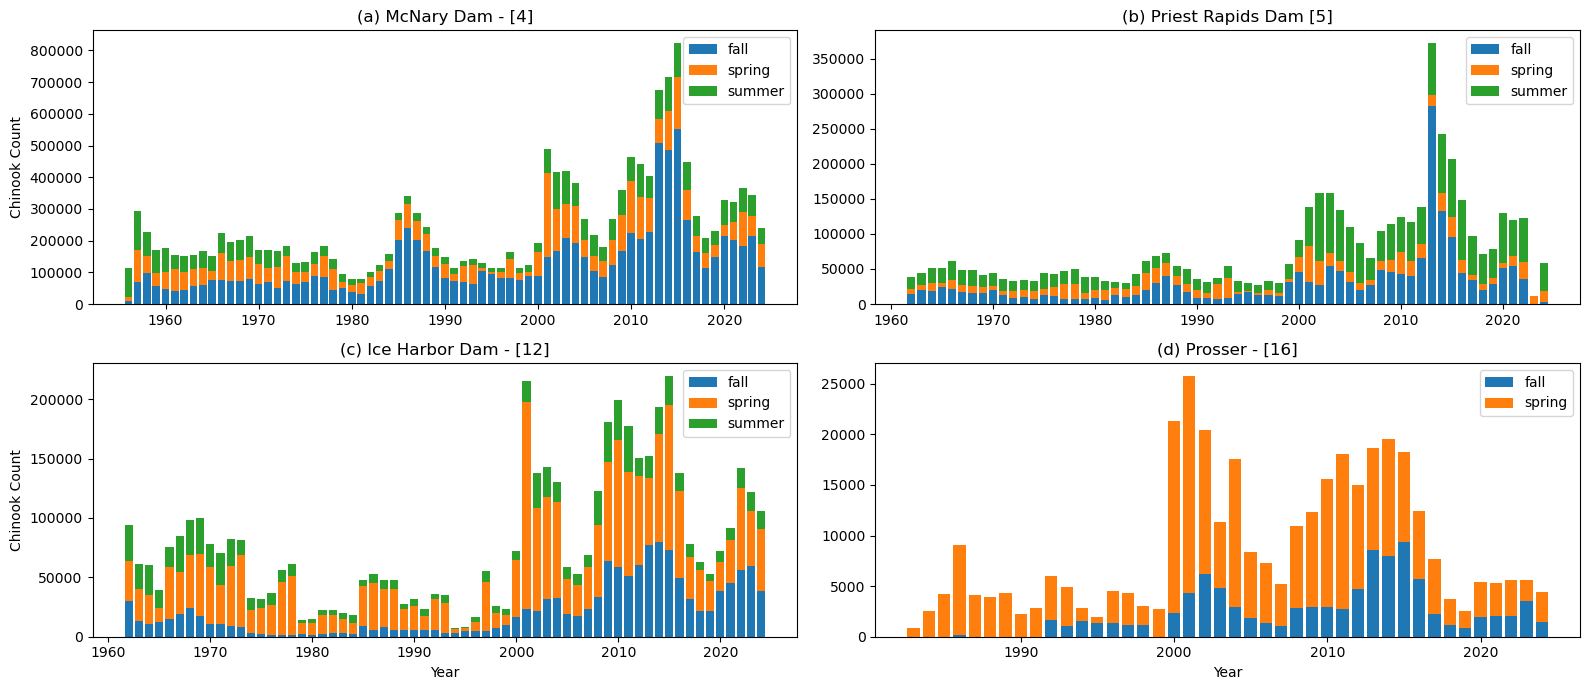

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 7))
plot_stacked_run_counts(mcn_fish_df, axs[0, 0], "(a) McNary Dam - [4]")
plot_stacked_run_counts(prd_fish_df, axs[0, 1], "(b) Priest Rapids Dam [5]")
plot_stacked_run_counts(ihr_fish_df, axs[1, 0], "(c) Ice Harbor Dam - [12]")
plot_stacked_run_counts(pro_fish_df, axs[1, 1], "(d) Prosser - [16]")

axs[0, 0].set_ylabel("Chinook Count")
axs[1, 0].set_ylabel("Chinook Count")

axs[1, 0].set_xlabel("Year")
axs[1, 1].set_xlabel("Year")

fig.tight_layout()
fig.savefig(proj_dir / "methods/02-fish_mass_bal/stacked_run_counts.png", dpi=600)

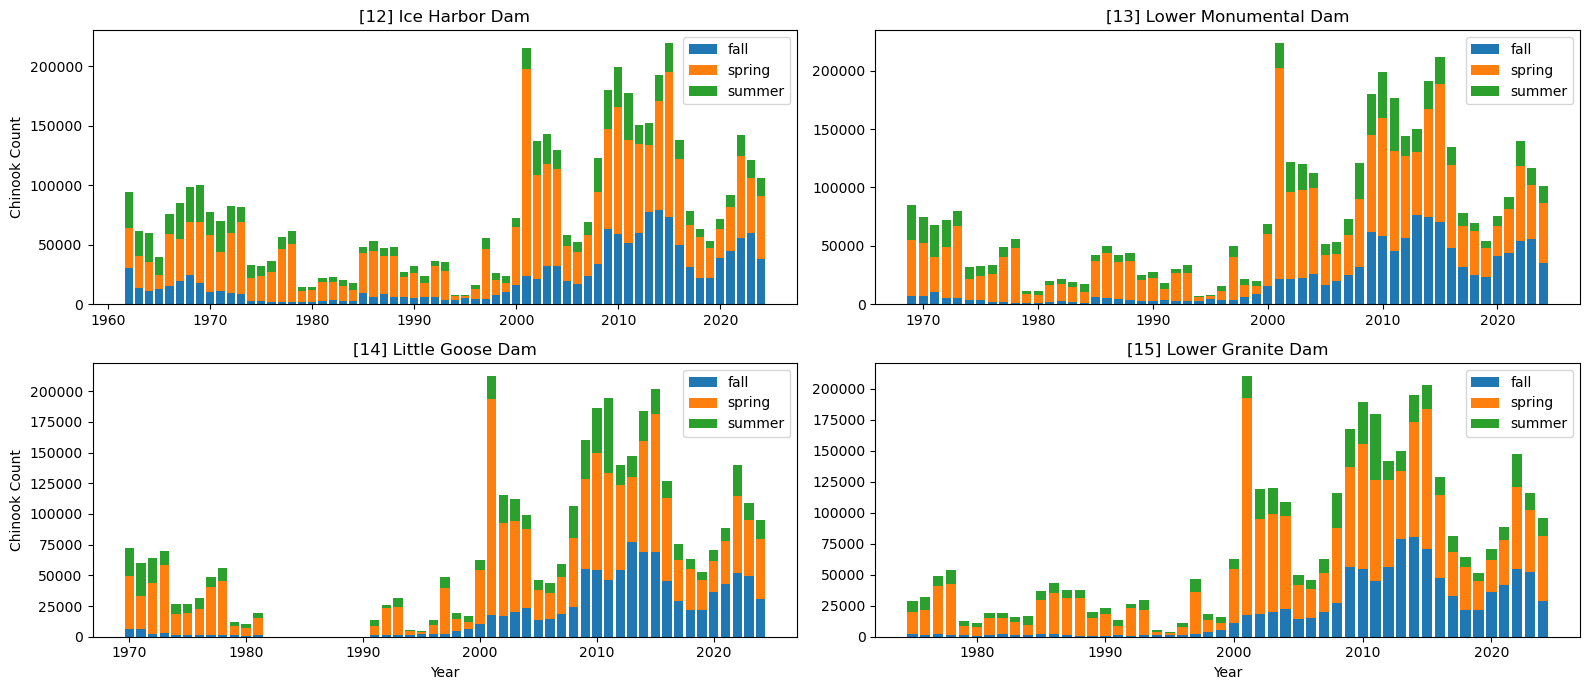

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 7))
plot_stacked_run_counts(ihr_fish_df, axs[0, 0], "[12] Ice Harbor Dam")
plot_stacked_run_counts(lmn_fish_df, axs[0, 1], "[13] Lower Monumental Dam")
plot_stacked_run_counts(lgs_fish_df, axs[1, 0], "[14] Little Goose Dam")
plot_stacked_run_counts(lwg_fish_df, axs[1, 1], "[15] Lower Granite Dam")

axs[0, 0].set_ylabel("Chinook Count")
axs[1, 0].set_ylabel("Chinook Count")

axs[1, 0].set_xlabel("Year")
axs[1, 1].set_xlabel("Year")

fig.tight_layout()

# Chinook population in the Hanford Reach

Using the concept of control volume to assess the adult migration and population in the Hanford reach.  
Adult Chinook entering the reach:  
* McNary Dam: $Ch_{4}$

Adult Chinook exiting the reach:  
* Priest Rapids Dam: $Ch_{5}$
* Ice Harbor Dam: $Ch_{12}$
* Proser: $Ch_{16}$

Adult Chinook population in the reach:
* Hanford Reach: $Ch_{hr}$

Change in adult chinook population in the reach ($\Delta Ch_{hr}$):  
* $\Delta Ch_{hr} = Ch_{4} - Ch_{5} - Ch_{12} - Ch_{16}$

In [49]:
mcnary_chinook_df = mcn_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()
priest_rapids_chinook_df = prd_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()
prosser_chinook_df = pro_fish_df[
    ["date", "year", "month", "day", "chinook", "run"]
].copy()
ice_harbor_chinook_df = ihr_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()

In [13]:
yearly_spring_chinook = (
    mcnary_chinook_df[(mcnary_chinook_df["run"] == "spring")]
    .groupby("year")["chinook"]
    .sum()
    .reset_index()
    .rename(columns={"chinook": "mcnary"})
    .merge(
        priest_rapids_chinook_df[(priest_rapids_chinook_df["run"] == "spring")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "priest_rapids"}),
        on="year",
        how="outer",
    )
    .merge(
        prosser_chinook_df[(prosser_chinook_df["run"] == "spring")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "prosser"}),
        on="year",
        how="outer",
    )
    .merge(
        ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "spring")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "ice_harbor"}),
        on="year",
        how="outer",
    )
)


# yearly_spring_chinook = yearly_spring_chinook[
#     (yearly_spring_chinook["year"] >= 2000) & (yearly_spring_chinook["year"] <= 2022)
# ]
yearly_spring_chinook["delta"] = (
    yearly_spring_chinook["mcnary"]
    - yearly_spring_chinook["priest_rapids"]
    - yearly_spring_chinook["prosser"]
    - yearly_spring_chinook["ice_harbor"]
)
yearly_spring_chinook["percent_delta"] = (
    yearly_spring_chinook["delta"] / yearly_spring_chinook["mcnary"]
)

In [14]:
yearly_summer_chinook = (
    mcnary_chinook_df[(mcnary_chinook_df["run"] == "summer")]
    .groupby("year")["chinook"]
    .sum()
    .reset_index()
    .rename(columns={"chinook": "mcnary"})
    .merge(
        priest_rapids_chinook_df[(priest_rapids_chinook_df["run"] == "summer")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "priest_rapids"}),
        on="year",
        how="outer",
    )
    .merge(
        ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "summer")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "ice_harbor"}),
        on="year",
        how="outer",
    )
)

# yearly_summer_chinook = yearly_summer_chinook[
#     (yearly_summer_chinook["year"] >= 2000) & (yearly_summer_chinook["year"] <= 2022)
# ]
yearly_summer_chinook["delta"] = (
    yearly_summer_chinook["mcnary"]
    - yearly_summer_chinook["priest_rapids"]
    - yearly_summer_chinook["ice_harbor"]
)
yearly_summer_chinook["percent_delta"] = (
    yearly_summer_chinook["delta"] / yearly_summer_chinook["mcnary"]
)

In [15]:
yearly_fall_chinook = (
    mcnary_chinook_df[(mcnary_chinook_df["run"] == "fall")]
    .groupby("year")["chinook"]
    .sum()
    .reset_index()
    .rename(columns={"chinook": "mcnary"})
    .merge(
        priest_rapids_chinook_df[(priest_rapids_chinook_df["run"] == "fall")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "priest_rapids"}),
        on="year",
        how="outer",
    )
    .merge(
        prosser_chinook_df[(prosser_chinook_df["run"] == "fall")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "prosser"}),
        on="year",
        how="outer",
    )
    .merge(
        ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "fall")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "ice_harbor"}),
        on="year",
        how="outer",
    )
)

# yearly_fall_chinook = yearly_fall_chinook[
#     (yearly_fall_chinook["year"] >= 2000) & (yearly_fall_chinook["year"] <= 2022)
# ]
yearly_fall_chinook["delta"] = (
    yearly_fall_chinook["mcnary"]
    - yearly_fall_chinook["priest_rapids"]
    - yearly_fall_chinook["prosser"]
    - yearly_fall_chinook["ice_harbor"]
)
yearly_fall_chinook["percent_delta"] = (
    yearly_fall_chinook["delta"] / yearly_fall_chinook["mcnary"]
)

<Axes: title={'center': 'Summer Chinook Delta'}, xlabel='year'>

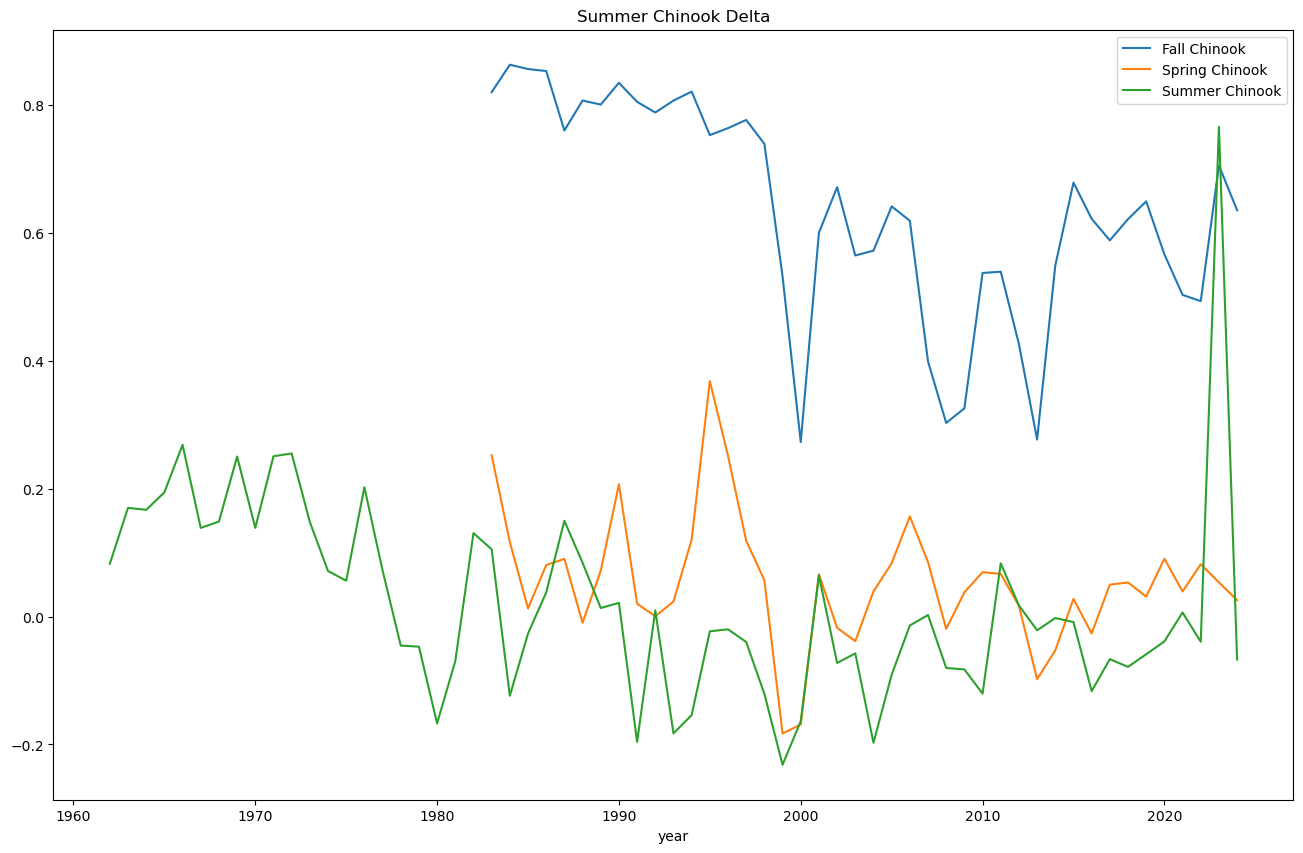

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
yearly_fall_chinook.plot(x="year", y="percent_delta", title="Fall Chinook Delta", ax=ax, label="Fall Chinook")
yearly_spring_chinook.plot(x="year", y="percent_delta", title="Spring Chinook Delta", ax=ax, label="Spring Chinook")
yearly_summer_chinook.plot(x="year", y="percent_delta", title="Summer Chinook Delta", ax=ax, label="Summer Chinook")

In [50]:
hanford_chinook_df = (
    mcnary_chinook_df[(mcnary_chinook_df["run"] == "fall")][["date", "chinook"]]
    .rename(columns={"chinook": "mcnary"})
    .merge(
        priest_rapids_chinook_df[(priest_rapids_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "priest_rapids"}),
        on="date",
        how="outer",
    )
    .merge(
        prosser_chinook_df[(prosser_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "prosser"}),
        on="date",
        how="outer",
    )
    .merge(
        ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "ice_harbor"}),
        on="date",
        how="outer",
    )
    .copy()
)
hanford_chinook_df["year"] = hanford_chinook_df["date"].dt.year
hanford_chinook_df[["mcnary", "priest_rapids", "prosser", "ice_harbor"]] = (
    hanford_chinook_df[["mcnary", "priest_rapids", "prosser", "ice_harbor"]]
    .copy()
    .fillna(0)
)

hanford_chinook_df["priest_rapids"] = hanford_chinook_df["priest_rapids"].shift(-5)
hanford_chinook_df["prosser"] = hanford_chinook_df["prosser"].shift(-7)
hanford_chinook_df["ice_harbor"] = hanford_chinook_df["ice_harbor"].shift(-3)

hanford_chinook_df["delta"] = (
    hanford_chinook_df["mcnary"]
    - hanford_chinook_df["priest_rapids"]
    - hanford_chinook_df["prosser"]
    - hanford_chinook_df["ice_harbor"]
)
hanford_chinook_df.dropna(subset=["year"], inplace=True)

In [51]:
years = hanford_chinook_df["year"].unique()
# sort out the years
years = np.sort(years)
years

array([1956., 1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964.,
       1965., 1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973.,
       1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982.,
       1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2020., 2021., 2022., 2023., 2024.])

In [52]:
_hanford_chinook_df = hanford_chinook_df.resample("W", on="date").sum().reset_index()
_hanford_chinook_df

,date,mcnary,priest_rapids,prosser,ice_harbor,year,delta
0,1956-08-12,1267.0,0.0,0.0,0.0,7824.0,1267.0
1,1956-08-19,1533.0,0.0,0.0,0.0,13692.0,1533.0
2,1956-08-26,734.0,0.0,0.0,0.0,13692.0,734.0
3,1956-09-02,460.0,0.0,0.0,0.0,13692.0,460.0
4,1956-09-09,1114.0,0.0,0.0,0.0,13692.0,1114.0
...,...,...,...,...,...,...,...
3550,2024-08-25,8960.0,1453.0,567.0,7379.0,14168.0,-439.0
3551,2024-09-01,17815.0,0.0,166.0,10870.0,14168.0,6779.0
3552,2024-09-08,31716.0,0.0,127.0,8957.0,14168.0,22632.0
3553,2024-09-15,37770.0,0.0,95.0,6700.0,14168.0,30975.0


In [53]:
thorr_df = pd.read_csv(proj_dir / "data/thorr/thorr_temp.csv")
thorr_df["date"] = pd.to_datetime(thorr_df["Date"])
columbia_df = thorr_df[thorr_df["RiverID"] == 9].copy()
snake_df = thorr_df[thorr_df["RiverID"] == 45].copy()
yakima_df = thorr_df[thorr_df["RiverID"] == 58].copy()
# thorr_df = thorr_df[thorr_df['RiverID'] == 9].copy()

In [54]:
# group columbia by reach
grouped_columbia = columbia_df.groupby("RKm")

_merged_columbia = pd.DataFrame(columns=["date"])
for group in grouped_columbia:
    resampled = group[1].resample("W", on="date").mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={"EstTempC": resampled["RKm"].iloc[0]}, inplace=True)
    _merged_columbia = pd.merge(
        _merged_columbia,
        resampled[["date", resampled["RKm"].iloc[0]]],
        on="date",
        how="outer",
    )

_merged_columbia["date"] = pd.to_datetime(_merged_columbia["date"])

# make date the index
_merged_columbia.set_index("date", inplace=True)
# sort by date
_merged_columbia.sort_index(inplace=True)

# group snake by reach
grouped_snake = snake_df.groupby("RKm")

_merged_snake = pd.DataFrame(columns=["date"])
for group in grouped_snake:
    resampled = group[1].resample("W", on="date").mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={"EstTempC": resampled["RKm"].iloc[0]}, inplace=True)
    _merged_snake = pd.merge(
        _merged_snake,
        resampled[["date", resampled["RKm"].iloc[0]]],
        on="date",
        how="outer",
    )

_merged_snake["date"] = pd.to_datetime(_merged_snake["date"])

# make date the index
_merged_snake.set_index("date", inplace=True)
# sort by date
_merged_snake.sort_index(inplace=True)

# group yakima by reach
grouped_yakima = yakima_df.groupby("RKm")

_merged_yakima = pd.DataFrame(columns=["date"])
for group in grouped_yakima:
    resampled = group[1].resample("W", on="date").mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={"EstTempC": resampled["RKm"].iloc[0]}, inplace=True)
    _merged_yakima = pd.merge(
        _merged_yakima,
        resampled[["date", resampled["RKm"].iloc[0]]],
        on="date",
        how="outer",
    )

_merged_yakima["date"] = pd.to_datetime(_merged_yakima["date"])

# make date the index
_merged_yakima.set_index("date", inplace=True)
# sort by date
_merged_yakima.sort_index(inplace=True)

In [55]:
_hanford_temp_df = _merged_columbia[range(460, 630, 10)].reset_index()
_hanford_temp_df["mean_temp"] = _hanford_temp_df.drop(columns=["date"]).mean(axis=1)
_hanford_chinook_df = _hanford_chinook_df.merge(_hanford_temp_df, on="date", how="left")
_hanford_chinook_df = allocate_runs(_hanford_chinook_df, run_schedules["mcnary"])

In [56]:
_up_priest_rapids = _merged_columbia[range(640, 670, 10)].reset_index()
_up_priest_rapids["mean_temp_up"] = _up_priest_rapids.drop(columns=["date"]).mean(axis=1)
_up_priest_rapids = allocate_runs(_up_priest_rapids, run_schedules["mcnary"])
_up_priest_rapids.dropna(
    subset=[
        "mean_temp_up",
    ]
).to_csv("up_priest_rapids.csv", index=False)

In [26]:
combined_han_pri = _hanford_chinook_df.merge(_up_priest_rapids, on="date", how="left")

In [27]:
combined_han_pri["temp_gradient"] = (
    combined_han_pri["mean_temp"] - combined_han_pri["mean_temp_up"]
)

In [28]:
combined_han_pri = combined_han_pri.dropna(subset=["temp_gradient"]).copy()
combined_han_pri["date"] = pd.to_datetime(combined_han_pri["date"])

In [27]:
combined_han_pri.to_csv("combined_han_pri.csv")

In [29]:
combined_han_pri

,date,mcnary,priest_rapids,prosser,ice_harbor,year_x,delta,460.0,470.0,480.0,...,620.0,mean_temp,run_x,640.0,650.0,660.0,mean_temp_up,year_y,run_y,temp_gradient
631,1982-11-15,0.0,12.0,0.0,0.0,1982,-12.0,NaN,NaN,NaN,...,11.2800,10.693750,NaN,NaN,11.230,11.0900,11.160000,1982.0,NaN,-0.466250
633,1982-12-15,0.0,0.0,0.0,0.0,1982,0.0,NaN,NaN,NaN,...,NaN,6.260000,NaN,NaN,5.870,NaN,5.870000,1982.0,NaN,0.390000
648,1983-07-31,722.0,48.0,0.0,16.0,1983,658.0,20.990,20.970,21.010000,...,19.7700,20.777059,summer,19.730000,19.560,19.8400,19.710000,1983.0,summer,1.067059
665,1984-04-15,0.0,0.0,0.0,0.0,1984,0.0,NaN,9.000,9.000000,...,8.1800,8.634444,spring,8.050000,8.090,8.1800,8.106667,1984.0,spring,0.527778
666,1984-04-30,0.0,0.0,0.0,0.0,1984,0.0,10.960,11.150,11.210000,...,9.2000,10.332500,spring,9.250000,9.760,9.5900,9.533333,1984.0,spring,0.799167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,2024-06-30,0.0,0.0,0.0,0.0,2024,0.0,18.370,19.730,20.096667,...,20.1175,19.447892,summer,18.120000,18.720,19.6375,18.825833,2024.0,summer,0.622059
1631,2024-07-15,0.0,0.0,0.0,0.0,2024,0.0,20.540,21.205,21.396667,...,21.0850,20.803922,summer,20.250000,21.495,19.7425,20.495833,2024.0,summer,0.308088
1632,2024-07-31,2332.0,111.0,0.0,1077.0,2024,1144.0,21.435,21.160,21.950000,...,21.2600,21.159020,summer,21.283333,21.330,20.6800,21.097778,2024.0,summer,0.061242
1633,2024-08-15,22601.0,2459.0,1074.0,13013.0,2024,6055.0,21.225,21.135,20.996667,...,20.9275,20.830441,fall,20.225000,20.945,20.4800,20.550000,2024.0,fall,0.280441


In [30]:
combined_han_pri[["mean_temp", "mean_temp_up", "temp_gradient"]]

,mean_temp,mean_temp_up,temp_gradient
631,10.693750,11.160000,-0.466250
633,6.260000,5.870000,0.390000
648,20.777059,19.710000,1.067059
665,8.634444,8.106667,0.527778
666,10.332500,9.533333,0.799167
...,...,...,...
1630,19.447892,18.825833,0.622059
1631,20.803922,20.495833,0.308088
1632,21.159020,21.097778,0.061242
1633,20.830441,20.550000,0.280441


In [57]:
_hanford_chinook_df.dropna(subset=["date"], inplace=True)

Text(0, 0.5, 'Change in Chinook Population')

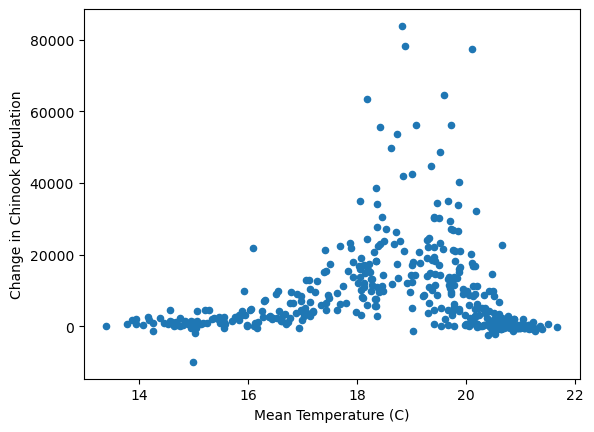

In [58]:
fig, ax = plt.subplots()
_hanford_chinook_df[_hanford_chinook_df["run"] == "fall"].plot.scatter(
    x="mean_temp",
    y="delta",
    ax=ax,
    # c='year',
    # cmap='viridis'
)
ax.set_xlabel("Mean Temperature (C)")
ax.set_ylabel("Change in Chinook Population")

In [32]:
_hanford_chinook_df.to_csv("hanford_chinook_mass_bal.csv", index=False)

In [67]:
_hanford_chinook_df.dropna(subset=["mean_temp", "delta"])

,date,mcnary,priest_rapids,prosser,ice_harbor,year,delta,460.0,470.0,480.0,...,610.0,620.0,mean_temp,run,group_5_year,month,day,doy,outflow(m3/d),days_from_fall
1371,1982-11-21,0.0,49.0,0.0,0.0,1982,-49.0,NaN,NaN,NaN,...,11.330,11.280,11.308000,NaN,NaN,11,21,325,NaN,105
1372,1982-11-28,0.0,0.0,0.0,0.0,1982,0.0,NaN,NaN,NaN,...,NaN,NaN,9.670000,NaN,NaN,11,28,332,NaN,112
1376,1982-12-26,0.0,0.0,0.0,0.0,1982,0.0,NaN,NaN,NaN,...,NaN,NaN,6.260000,NaN,NaN,12,26,360,NaN,140
1382,1983-02-06,0.0,0.0,0.0,0.0,1983,0.0,3.26,3.22,3.340,...,3.430,3.200,3.345000,NaN,NaN,2,6,37,NaN,-183
1409,1983-08-14,722.0,616.0,0.0,40.0,1983,66.0,20.99,20.97,21.010,...,20.250,19.770,20.777059,fall,NaN,8,14,226,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,2024-08-11,932.0,352.0,302.0,1077.0,2024,-799.0,NaN,NaN,NaN,...,21.670,21.350,21.388750,fall,NaN,8,11,224,NaN,3
3549,2024-08-18,3792.0,765.0,214.0,3266.0,2024,-453.0,21.62,20.46,21.260,...,21.050,21.430,20.957812,fall,NaN,8,18,231,NaN,10
3550,2024-08-25,8960.0,1453.0,567.0,7379.0,2024,-439.0,21.65,21.36,21.065,...,20.525,21.265,21.052059,fall,NaN,8,25,238,NaN,17
3551,2024-09-01,17815.0,0.0,166.0,10870.0,2024,6779.0,20.80,20.91,20.860,...,20.350,20.590,20.598235,fall,NaN,9,1,245,NaN,24


In [ ]:
_hanford_chinook_df.dropna(subset=["mean_temp", "delta"]).to_csv(
    "hanford_chinook_mass_bal_no_na.csv", index=False
)

In [68]:
_hanford_chinook_df["delta_ratio"] = (
    _hanford_chinook_df["delta"] / _hanford_chinook_df["mcnary"]
)

In [69]:
_hanford_chinook_df['year']

1371    1982
1372    1982
1376    1982
1382    1983
1409    1983
        ... 
3548    2024
3549    2024
3550    2024
3551    2024
3552    2024
Name: year, Length: 1680, dtype: int64

In [70]:
# assign 5-year categories from 2000 to 2022
interval = 1
_hanford_chinook_df["group_5_year"] = pd.cut(
    _hanford_chinook_df["year"],
    bins=range(1985, 2023, interval),
    # labels=[f"{x}-{x+interval-1}" for x in range(1985, 2023, interval)][:-1],
    labels=[f"{x}" for x in range(1985, 2023, interval)][:-1],
)

In [71]:
_hanford_chinook_df

,date,mcnary,priest_rapids,prosser,ice_harbor,year,delta,460.0,470.0,480.0,...,620.0,mean_temp,run,group_5_year,month,day,doy,outflow(m3/d),days_from_fall,delta_ratio
1371,1982-11-21,0.0,49.0,0.0,0.0,1982,-49.0,NaN,NaN,NaN,...,11.280,11.308000,NaN,NaN,11,21,325,NaN,105,-inf
1372,1982-11-28,0.0,0.0,0.0,0.0,1982,0.0,NaN,NaN,NaN,...,NaN,9.670000,NaN,NaN,11,28,332,NaN,112,NaN
1376,1982-12-26,0.0,0.0,0.0,0.0,1982,0.0,NaN,NaN,NaN,...,NaN,6.260000,NaN,NaN,12,26,360,NaN,140,NaN
1382,1983-02-06,0.0,0.0,0.0,0.0,1983,0.0,3.26,3.22,3.340,...,3.200,3.345000,NaN,NaN,2,6,37,NaN,-183,NaN
1409,1983-08-14,722.0,616.0,0.0,40.0,1983,66.0,20.99,20.97,21.010,...,19.770,20.777059,fall,NaN,8,14,226,NaN,6,0.091413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,2024-08-11,932.0,352.0,302.0,1077.0,2024,-799.0,NaN,NaN,NaN,...,21.350,21.388750,fall,NaN,8,11,224,NaN,3,-0.857296
3549,2024-08-18,3792.0,765.0,214.0,3266.0,2024,-453.0,21.62,20.46,21.260,...,21.430,20.957812,fall,NaN,8,18,231,NaN,10,-0.119462
3550,2024-08-25,8960.0,1453.0,567.0,7379.0,2024,-439.0,21.65,21.36,21.065,...,21.265,21.052059,fall,NaN,8,25,238,NaN,17,-0.048996
3551,2024-09-01,17815.0,0.0,166.0,10870.0,2024,6779.0,20.80,20.91,20.860,...,20.590,20.598235,fall,NaN,9,1,245,NaN,24,0.380522


In [72]:
_hanford_chinook_df['month'] = _hanford_chinook_df['date'].dt.month
_hanford_chinook_df['day'] = _hanford_chinook_df['date'].dt.day
_hanford_chinook_df['doy'] = _hanford_chinook_df['date'].dt.dayofyear
_hanford_chinook_df['year'] = _hanford_chinook_df['date'].dt.year


_hanford_chinook_df.dropna(subset=['mean_temp']).to_csv("hanford_chinook_mass_bal_sm.csv", index=False)

In [73]:
_hanford_chinook_df = _hanford_chinook_df.merge(prd_conditions_df_weekly[['date','outflow(m3/d)']], on='date', how='left').dropna(subset=['mean_temp'])
_hanford_chinook_df.to_csv("hanford_chinook_mass_bal_sm.csv", index=False)

In [74]:
_hanford_chinook_df.columns

Index([           'date',          'mcnary',   'priest_rapids',
               'prosser',      'ice_harbor',            'year',
                 'delta',             460.0,             470.0,
                   480.0,             490.0,             500.0,
                   510.0,             520.0,             530.0,
                   540.0,             550.0,             560.0,
                   570.0,             580.0,             590.0,
                   600.0,             610.0,             620.0,
             'mean_temp',             'run',    'group_5_year',
                 'month',             'day',             'doy',
       'outflow(m3/d)_x',  'days_from_fall',     'delta_ratio',
       'outflow(m3/d)_y'],
      dtype='object')

In [75]:
# create new column that picks the year for the fall run, combines it with the day and month for the fall run to create a new date column, and then calculates the days from the fall run
_hanford_chinook_df['days_from_fall'] = (_hanford_chinook_df['date'] - pd.to_datetime(_hanford_chinook_df['year'].astype(str) + f"-{run_schedules['mcnary']['fall'][0]}")).dt.days + 1

_hanford_chinook_df.to_csv("hanford_chinook_mass_bal_sm.csv", index=False)

In [76]:
min(_hanford_chinook_df[_hanford_chinook_df["run"] == "fall"]['days_from_fall'].to_list())

1

<Axes: xlabel='doy', ylabel='mean_temp'>

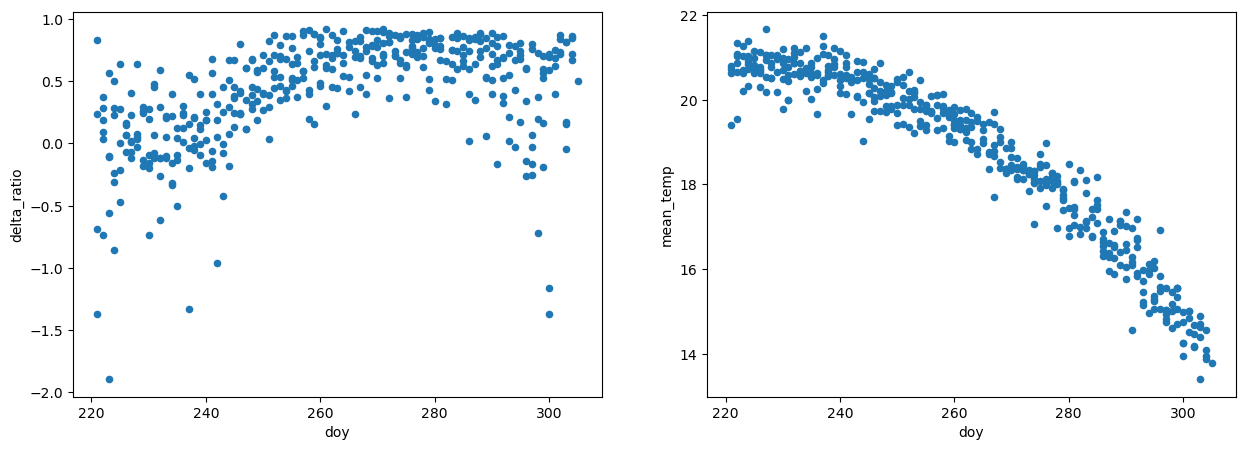

In [78]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_hanford_chinook_df[(_hanford_chinook_df["run"] == "fall") & (_hanford_chinook_df["year"] >= 1985)].plot.scatter(
        x="doy",
        y="delta_ratio",
        ax=ax,
        # c='group_5_year',
        # cmap='viridis'
)
# for group_5 in _hanford_chinook_df["group_5_year"].unique():
#     _hanford_chinook_df[(_hanford_chinook_df["run"] == "fall") & (_hanford_chinook_df['group_5_year']==group_5)].plot.scatter(
#         x="mean_temp",
#         y="delta_ratio",
#         ax=ax,
#         label=group_5,
#         c='year',
#         # cmap='viridis'
#     )
# ax.set_xlabel("Mean Temperature (C)")
# ax.set_ylabel("Change in Chinook Population")
# 1-1 line
# x = np.linspace(0, 1e6, 100)
# ax.plot(x, x, color='red')
# ax.set_ylim(-.2, 1.03)

_hanford_chinook_df[(_hanford_chinook_df["run"] == "fall") & (_hanford_chinook_df["year"] >= 1965)].plot.scatter(
        x="doy",
        y="mean_temp",
        ax=ax2,
        # c='group_5_year',
        # cmap='viridis'
)


<Axes: xlabel='doy', ylabel='delta'>

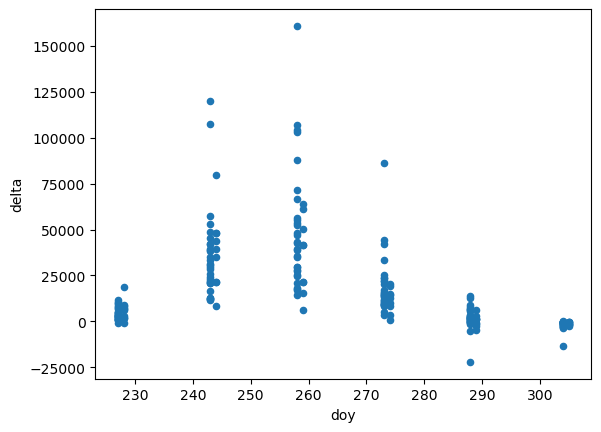

In [45]:
fig, ax = plt.subplots()
_hanford_chinook_df[(_hanford_chinook_df["run"] == "fall") & (_hanford_chinook_df["year"] >= 1985)].plot.scatter(
        x="doy",
        y="delta",
        ax=ax,
        # c='group_5_year',
        # cmap='viridis'
)

In [46]:
# find mean, median, mode, 5th, 25th, 75th, and 95th percentiles for each 5-year group
central_tendencies = _hanford_chinook_df[(_hanford_chinook_df["run"] == "fall")].groupby('group_5_year').agg(
    mean_delta_ratio=('delta_ratio', 'mean'),
    median_delta_ratio=('delta_ratio', 'median'),
    mode_delta_ratio=('delta_ratio', lambda x: x.mode().iloc[0]),
    p5_delta_ratio=('delta_ratio', lambda x: x.quantile(.05)),
    p25_delta_ratio=('delta_ratio', lambda x: x.quantile(.25)),
    p75_delta_ratio=('delta_ratio', lambda x: x.quantile(.75)),
    p95_delta_ratio=('delta_ratio', lambda x: x.quantile(.95)),
    mean_mean_temp=('mean_temp', 'mean'),
    median_mean_temp=('mean_temp', 'median'),
    # mode_mean_temp=('mean_temp', lambda x: x.mode().iloc[0]),
    p5_mean_temp=('mean_temp', lambda x: x.quantile(.05)),
    p25_mean_temp=('mean_temp', lambda x: x.quantile(.25)),
    p75_mean_temp=('mean_temp', lambda x: x.quantile(.75)),
    p95_mean_temp=('mean_temp', lambda x: x.quantile(.95)),
    n_samples = ('delta_ratio', 'count'),
    mcnary_sum = ('mcnary', 'sum'),
    priest_rapids_sum = ('priest_rapids', 'sum'),
    prosser_sum = ('prosser', 'sum'),
    ice_harbor_sum = ('ice_harbor', 'sum'),
).reset_index()

# mean_temp_central_tendencies = _hanford_chinook_df[(_hanford_chinook_df["run"] == "fall")].groupby('group_5_year').agg(
#     mean_mean_temp=('mean_temp', 'mean'),
#     median_mean_temp=('mean_temp', 'median'),
#     mode_mean_temp=('mean_temp', lambda x: x.mode().iloc[0]),
#     p5_mean_temp=('mean_temp', lambda x: x.quantile(.05)),
#     p25_mean_temp=('mean_temp', lambda x: x.quantile(.25)),
#     p75_mean_temp=('mean_temp', lambda x: x.quantile(.75)),
#     p95_mean_temp=('mean_temp', lambda x: x.quantile(.95)),
# ).reset_index()

# del_r_central_tendencies.to_csv("del_r_central_tendencies.csv", index=False)
# mean_temp_central_tendencies.to_csv("mean_temp_central_tendencies.csv", index=False)


In [47]:
central_tendencies['yearly_delta'] = central_tendencies['mcnary_sum'] - central_tendencies['priest_rapids_sum'] - central_tendencies['prosser_sum'] - central_tendencies['ice_harbor_sum']
central_tendencies['yearly_delta_ratio'] = central_tendencies['yearly_delta'] / central_tendencies['mcnary_sum']

In [46]:
central_tendencies.to_csv("hanford_central_tendencies.csv", index=False)

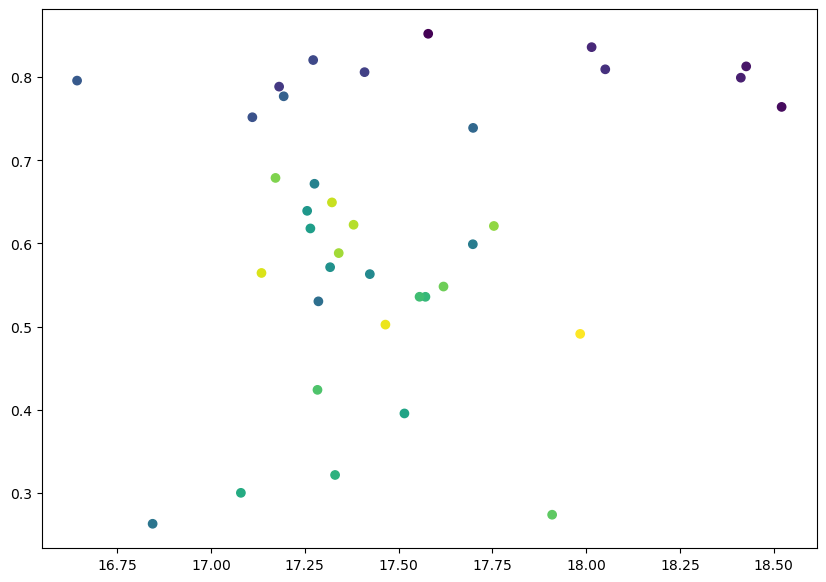

In [48]:
fig, ax = plt.subplots(figsize=(10, 7)) 
# central_tendencies.plot(x="mean_mean_temp", y="mean_delta_ratio", kind="scatter")
# ax.scatter(central_tendencies["mean_mean_temp"], central_tendencies["mean_delta_ratio"], c=central_tendencies["group_5_year"].astype(int), cmap='viridis')
ax.scatter(central_tendencies["mean_mean_temp"], central_tendencies["yearly_delta_ratio"], c=central_tendencies["group_5_year"].astype(int), cmap='viridis')

# zip joins x and y coordinates in pairs
for x,y,group in zip(central_tendencies["mean_mean_temp"], central_tendencies["mean_delta_ratio"],  central_tendencies["group_5_year"]):

    label = "{}".format(group)

    # plt.annotate(label, # this is the text
    #              (x,y), # these are the coordinates to position the label
    #              textcoords="offset points", # how to position the text
    #              xytext=(0,10), # distance from text to points (x,y)
    #              ha='center') # horizontal alignment can be left, right or center
    
# add a horizontal wisker for the 5th, 25th, 75th, and 95th percentiles
# ax.errorbar(
#     central_tendencies["mean_mean_temp"],
#     central_tendencies["mean_delta_ratio"],
#     # yerr=[
#     #     central_tendencies["mean_delta_ratio"] - central_tendencies["p5_delta_ratio"],
#     #     central_tendencies["p95_delta_ratio"] - central_tendencies["mean_delta_ratio"],
#     # ],
#     xerr=[
#         central_tendencies["mean_mean_temp"] - central_tendencies["p25_mean_temp"],
#         central_tendencies["p75_mean_temp"] - central_tendencies["mean_mean_temp"],
#     ],
#     fmt="o",
#     color="black",
# )

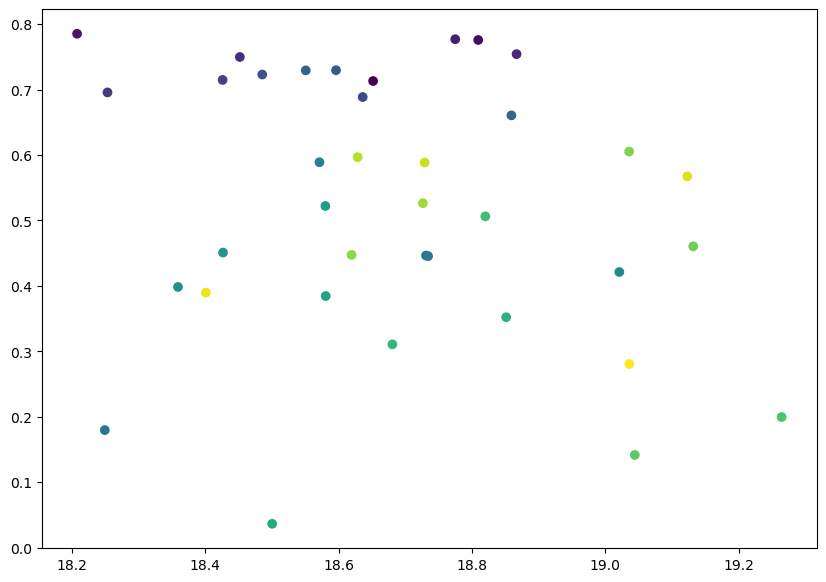

In [48]:
fig, ax = plt.subplots(figsize=(10, 7)) 
# central_tendencies.plot(x="mean_mean_temp", y="mean_delta_ratio", kind="scatter")
ax.scatter(central_tendencies["mean_mean_temp"], central_tendencies["mean_delta_ratio"], c=central_tendencies["group_5_year"].astype(int), cmap='viridis')
# ax.scatter(central_tendencies["mean_mean_temp"], central_tendencies["yearly_delta_ratio"], c=central_tendencies["group_5_year"].astype(int), cmap='viridis')

# zip joins x and y coordinates in pairs
for x,y,group in zip(central_tendencies["mean_mean_temp"], central_tendencies["mean_delta_ratio"],  central_tendencies["group_5_year"]):

    label = "{}".format(group)

    # plt.annotate(label, # this is the text
    #              (x,y), # these are the coordinates to position the label
    #              textcoords="offset points", # how to position the text
    #              xytext=(0,10), # distance from text to points (x,y)
    #              ha='center') # horizontal alignment can be left, right or center
    
# add a horizontal wisker for the 5th, 25th, 75th, and 95th percentiles
# ax.errorbar(
#     central_tendencies["mean_mean_temp"],
#     central_tendencies["mean_delta_ratio"],
#     # yerr=[
#     #     central_tendencies["mean_delta_ratio"] - central_tendencies["p5_delta_ratio"],
#     #     central_tendencies["p95_delta_ratio"] - central_tendencies["mean_delta_ratio"],
#     # ],
#     xerr=[
#         central_tendencies["mean_mean_temp"] - central_tendencies["p25_mean_temp"],
#         central_tendencies["p75_mean_temp"] - central_tendencies["mean_mean_temp"],
#     ],
#     fmt="o",
#     color="black",
# )

<Axes: xlabel='date'>

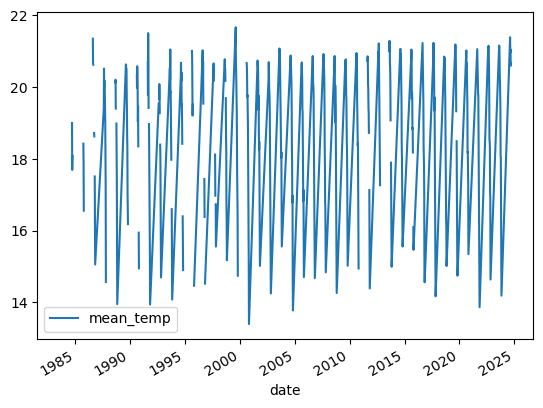

In [43]:
fig, ax = plt.subplots()
_hanford_chinook_df[_hanford_chinook_df["run"] == "fall"].plot(
    x="date",
    y="mean_temp",
    ax=ax,
    # c='year',
    # cmap='viridis'
)
# _hanford_chinook_df[_hanford_chinook_df["run"] == "fall"].plot(
#     x="date",
#     y="delta_ratio",
#     ax=ax,
#     # c='year',
#     # cmap='viridis'
# )
# ax.set_xlabel("Mean Temperature (C)")
# ax.set_ylabel("Change in Chinook Population")
# 1-1 line
# x = np.linspace(0, 1e6, 100)
# ax.plot(x, x, color='red')


## Wannapum to Rock Island

In [266]:
wannapum_chinook_df = wan_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()
rock_island_chinook_df = ris_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()

In [267]:
wan_ris_chinook_df = (
    wannapum_chinook_df[(wannapum_chinook_df["run"] == "fall")][["date", "chinook"]]
    .rename(columns={"chinook": "wannapum"})
    .merge(
        rock_island_chinook_df[(rock_island_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "rock_island"}),
        on="date",
        how="outer",
    )
)

wan_ris_chinook_df["year"] = wan_ris_chinook_df["date"].dt.year
wan_ris_chinook_df[["wannapum", "rock_island"]] = (
    wan_ris_chinook_df[["wannapum", "rock_island"]].copy().fillna(0)
)
wan_ris_chinook_df["delta"] = (
    wan_ris_chinook_df["wannapum"] - wan_ris_chinook_df["rock_island"]
)
wan_ris_chinook_df.dropna(subset=["year"], inplace=True)

In [268]:
_wan_ris_chinook_df = wan_ris_chinook_df.resample("W", on="date").sum().reset_index()

In [269]:
_wan_ris_temp_df = _merged_columbia[range(670, 720, 10)].reset_index()
_wan_ris_temp_df["mean_temp"] = _wan_ris_temp_df.drop(columns=["date"]).mean(axis=1)
_wan_ris_chinook_df = _wan_ris_chinook_df.merge(_wan_ris_temp_df, on="date", how="left")
_wan_ris_chinook_df = allocate_runs(_wan_ris_chinook_df, run_schedules["rock_island"])

In [270]:
_wan_ris_chinook_df["delta_ratio"] = (
    _wan_ris_chinook_df["delta"] / _wan_ris_chinook_df["wannapum"]
)

_wan_ris_chinook_df.dropna(subset=["mean_temp", "delta"]).to_csv(
    "wan_ris_chinook_mass_bal.csv", index=False
)

In [278]:
# assign 5-year categories from 2000 to 2022
interval = 5
_wan_ris_chinook_df["group_5_year"] = pd.cut(
    _wan_ris_chinook_df["year"],
    bins=range(1977, 2026, interval),
    labels=[f"{x}-{x+interval-1}" for x in range(1977, 2026, interval)][:-1],
)

In [279]:
wan_ris_central_tendencies = _wan_ris_chinook_df[(_wan_ris_chinook_df["run"] == "fall")].groupby('group_5_year').agg(
    mean_delta_ratio=('delta_ratio', 'mean'),
    median_delta_ratio=('delta_ratio', 'median'),
    mode_delta_ratio=('delta_ratio', lambda x: x.mode().iloc[0]),
    p5_delta_ratio=('delta_ratio', lambda x: x.quantile(.05)),
    p25_delta_ratio=('delta_ratio', lambda x: x.quantile(.25)),
    p75_delta_ratio=('delta_ratio', lambda x: x.quantile(.75)),
    p95_delta_ratio=('delta_ratio', lambda x: x.quantile(.95)),
    mean_mean_temp=('mean_temp', 'mean'),
    median_mean_temp=('mean_temp', 'median'),
    # mode_mean_temp=('mean_temp', lambda x: x.mode().iloc[0]),
    p5_mean_temp=('mean_temp', lambda x: x.quantile(.05)),
    p25_mean_temp=('mean_temp', lambda x: x.quantile(.25)),
    p75_mean_temp=('mean_temp', lambda x: x.quantile(.75)),
    p95_mean_temp=('mean_temp', lambda x: x.quantile(.95)),
    n_samples = ('delta_ratio', 'count')
).reset_index()

<Axes: xlabel='mean_mean_temp', ylabel='mean_delta_ratio'>

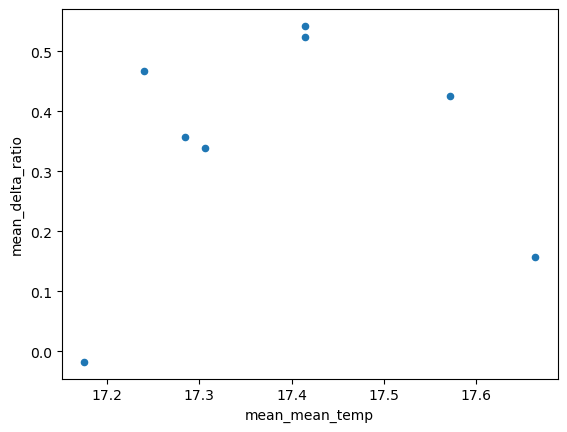

In [280]:
wan_ris_central_tendencies.plot(x="mean_mean_temp", y="mean_delta_ratio", kind="scatter")

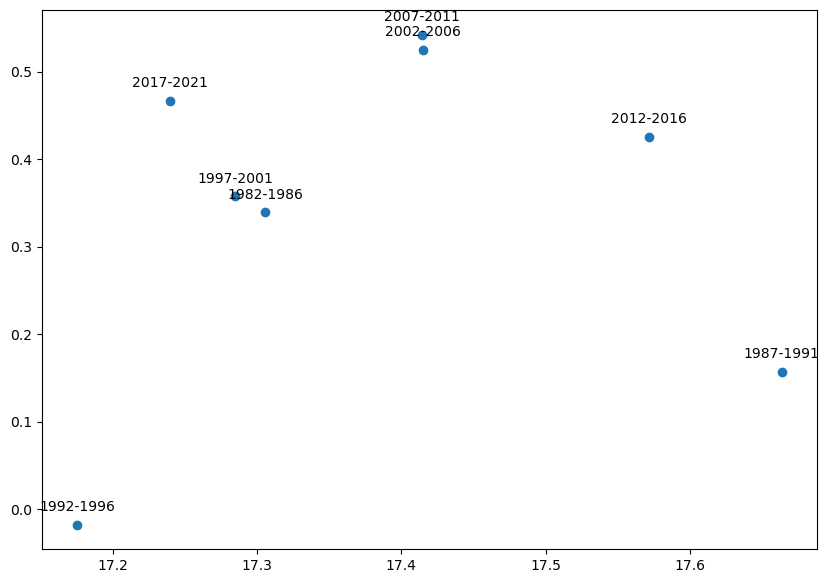

In [281]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(wan_ris_central_tendencies["mean_mean_temp"], wan_ris_central_tendencies["mean_delta_ratio"])

# zip joins x and y coordinates in pairs
for x,y,group in zip(wan_ris_central_tendencies["mean_mean_temp"], wan_ris_central_tendencies["mean_delta_ratio"],  wan_ris_central_tendencies["group_5_year"]):

    label = "{}".format(group)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Ice Harbor to Lower Monumental

In [285]:
ice_harbor_chinook_df = ihr_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()
lower_monumental_chinook_df = lmn_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()

In [286]:
ihr_lmn_chinook_df = (
    ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "fall")][["date", "chinook"]]
    .rename(columns={"chinook": "ice_harbor"})
    .merge(
        lower_monumental_chinook_df[(lower_monumental_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "lower_monumental"}),
        on="date",
        how="outer",
    )
)

ihr_lmn_chinook_df["year"] = ihr_lmn_chinook_df["date"].dt.year
ihr_lmn_chinook_df[["ice_harbor", "lower_monumental"]] = (
    ihr_lmn_chinook_df[["ice_harbor", "lower_monumental"]].copy().fillna(0)
)
ihr_lmn_chinook_df["delta"] = (
    ihr_lmn_chinook_df["ice_harbor"] - ihr_lmn_chinook_df["lower_monumental"]
)
ihr_lmn_chinook_df.dropna(subset=["year"], inplace=True)

In [288]:
_ihr_lmn_chinook_df = ihr_lmn_chinook_df.resample("W", on="date").sum().reset_index()

In [289]:
_ihr_lmn_temp_df = _merged_snake[range(20, 50, 10)].reset_index()
_ihr_lmn_temp_df["mean_temp"] = _ihr_lmn_temp_df.drop(columns=["date"]).mean(axis=1)
_ihr_lmn_chinook_df = _ihr_lmn_chinook_df.merge(_ihr_lmn_temp_df, on="date", how="left")
_ihr_lmn_chinook_df = allocate_runs(_ihr_lmn_chinook_df, run_schedules["rock_island"])

In [291]:
_ihr_lmn_chinook_df["delta_ratio"] = (
    _ihr_lmn_chinook_df["delta"] / _ihr_lmn_chinook_df["ice_harbor"]
)

_ihr_lmn_chinook_df.dropna(subset=["mean_temp", "delta"]).to_csv(
    "ihr_lmn_chinook_mass_bal.csv", index=False
)

In [299]:
# assign 5-year categories from 2000 to 2022
interval = 5
_ihr_lmn_chinook_df["group_5_year"] = pd.cut(
    _ihr_lmn_chinook_df["year"],
    bins=range(1985, 2026, interval),
    labels=[f"{x}-{x+interval-1}" for x in range(1985, 2026, interval)][:-1],
)

In [300]:
ihr_lmn_central_tendencies = _ihr_lmn_chinook_df[(_ihr_lmn_chinook_df["run"] == "fall")].groupby('group_5_year').agg(
    mean_delta_ratio=('delta_ratio', 'mean'),
    median_delta_ratio=('delta_ratio', 'median'),
    mode_delta_ratio=('delta_ratio', lambda x: x.mode().iloc[0]),
    p5_delta_ratio=('delta_ratio', lambda x: x.quantile(.05)),
    p25_delta_ratio=('delta_ratio', lambda x: x.quantile(.25)),
    p75_delta_ratio=('delta_ratio', lambda x: x.quantile(.75)),
    p95_delta_ratio=('delta_ratio', lambda x: x.quantile(.95)),
    mean_mean_temp=('mean_temp', 'mean'),
    median_mean_temp=('mean_temp', 'median'),
    # mode_mean_temp=('mean_temp', lambda x: x.mode().iloc[0]),
    p5_mean_temp=('mean_temp', lambda x: x.quantile(.05)),
    p25_mean_temp=('mean_temp', lambda x: x.quantile(.25)),
    p75_mean_temp=('mean_temp', lambda x: x.quantile(.75)),
    p95_mean_temp=('mean_temp', lambda x: x.quantile(.95)),
    n_samples = ('delta_ratio', 'count')
).reset_index()

<Axes: xlabel='mean_mean_temp', ylabel='mean_delta_ratio'>

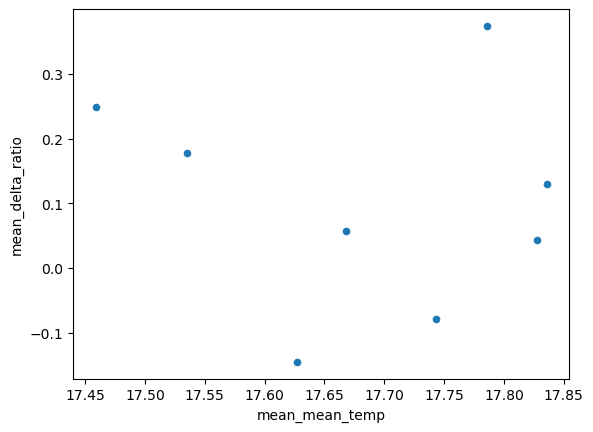

In [301]:
ihr_lmn_central_tendencies.plot(x="mean_mean_temp", y="mean_delta_ratio", kind="scatter")

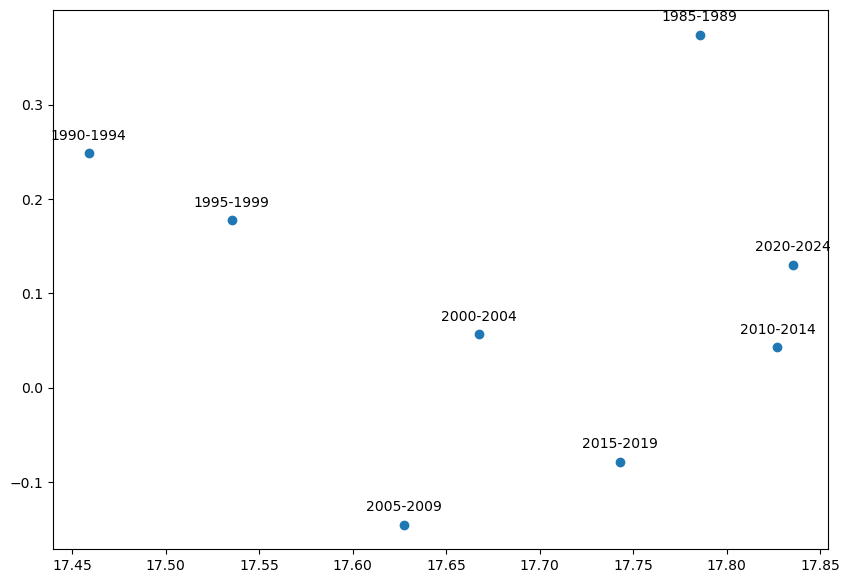

In [302]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(ihr_lmn_central_tendencies["mean_mean_temp"], ihr_lmn_central_tendencies["mean_delta_ratio"])

# zip joins x and y coordinates in pairs
for x,y,group in zip(ihr_lmn_central_tendencies["mean_mean_temp"], ihr_lmn_central_tendencies["mean_delta_ratio"],  ihr_lmn_central_tendencies["group_5_year"]):

    label = "{}".format(group)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [303]:

ihr_lmn_central_tendencies.to_csv("ihr_lmn_central_tendencies.csv", index=False)

## Snake River
Ice Harbor - Lower Monumental - Little Goose

In [126]:
ihr_chinook_df = ihr_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].dropna(subset=["chinook",]).copy()
lmn_chinook_df = lmn_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].dropna(subset=["chinook",]).copy()
lgs_chinook_df = lgs_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].dropna(subset=["chinook",]).copy()
lwg_chinook_df = lwg_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].dropna(subset=["chinook",]).copy()

In [127]:
ihr_lwg_chinook_df = (
    ihr_chinook_df[(ihr_chinook_df["run"] == "fall")][["date", "chinook"]]
    .rename(columns={"chinook": "ihr"})
    .merge(
        lmn_chinook_df[(lmn_chinook_df["run"] == "fall")][["date", "chinook"]].rename(
            columns={"chinook": "lmn"}
        ),
        on="date",
        how="outer",
    )
    .merge(
        lgs_chinook_df[(lgs_chinook_df["run"] == "fall")][["date", "chinook"]].rename(
            columns={"chinook": "lgs"}
        ),
        on="date",
        how="outer",
    )
    .merge(
        lwg_chinook_df[(lwg_chinook_df["run"] == "fall")][["date", "chinook"]].rename(
            columns={"chinook": "lwg"}
        ),
        on="date",
        how="outer",
    )
    .copy()
)
ihr_lwg_chinook_df["year"] = ihr_lwg_chinook_df["date"].dt.year
ihr_lwg_chinook_df[["ihr", "lmn", "lgs", "lwg"]] = (
    ihr_lwg_chinook_df[["ihr", "lmn", "lgs", "lwg"]].copy().fillna(0)
)
ihr_lwg_chinook_df["ihr_lmn_delta"] = (
    ihr_lwg_chinook_df["ihr"] - ihr_lwg_chinook_df["lmn"]
)
# ihr_lwg_chinook_df["ihr_lmn_delta_ratio"] = (
#     ihr_lwg_chinook_df["ihr_lmn_delta"] / ihr_lwg_chinook_df["ihr"]
# )

ihr_lwg_chinook_df["lmn_lgs_delta"] = (
    ihr_lwg_chinook_df["lmn"] - ihr_lwg_chinook_df["lgs"]
)
# ihr_lwg_chinook_df["lmn_lgs_delta_ratio"] = (
#     ihr_lwg_chinook_df["lmn_lgs_delta"] / ihr_lwg_chinook_df["lmn"]
# )

ihr_lwg_chinook_df["lgs_lwg_delta"] = (
    ihr_lwg_chinook_df["lgs"] - ihr_lwg_chinook_df["lwg"]
)
# ihr_lwg_chinook_df["lgs_lwg_delta_ratio"] = (
#     ihr_lwg_chinook_df["lgs_lwg_delta"] / ihr_lwg_chinook_df["lgs"]
# )
ihr_lwg_chinook_df.dropna(subset=["year"], inplace=True)

In [128]:
ihr_lwg_chinook_df["ihr_lmn_delta"] / ihr_lwg_chinook_df["ihr"]

0       1.000000
1       1.000000
2      -6.000000
3       0.000000
4       0.428571
          ...   
6522         NaN
6523         NaN
6524         NaN
6525         NaN
6526         NaN
Length: 6527, dtype: float64

In [129]:
ihr_lwg_chinook_df_weekly = ihr_lwg_chinook_df.resample("W", on="date").sum(numeric_only=True).reset_index()

In [130]:
ihr_lwg_chinook_df_weekly["ihr_lmn_delta_ratio"] = (
    ihr_lwg_chinook_df_weekly["ihr_lmn_delta"] / ihr_lwg_chinook_df_weekly["ihr"]
)
ihr_lwg_chinook_df_weekly["lmn_lgs_delta_ratio"] = (
    ihr_lwg_chinook_df_weekly["lmn_lgs_delta"] / ihr_lwg_chinook_df_weekly["lmn"]
)
ihr_lwg_chinook_df_weekly["lgs_lwg_delta_ratio"] = (
    ihr_lwg_chinook_df_weekly["lgs_lwg_delta"] / ihr_lwg_chinook_df_weekly["lgs"]
)


In [131]:
thorr_df = pd.read_csv(proj_dir / "data/thorr/thorr_temp.csv")
thorr_df["date"] = pd.to_datetime(thorr_df["Date"])
columbia_df = thorr_df[thorr_df["RiverID"] == 9].copy()
snake_df = thorr_df[thorr_df["RiverID"] == 45].copy()
yakima_df = thorr_df[thorr_df["RiverID"] == 58].copy()
# thorr_df = thorr_df[thorr_df['RiverID'] == 9].copy()

In [132]:
# group snake by reach
grouped_snake = snake_df.groupby("RKm")

_merged_snake = pd.DataFrame(columns=["date"])
for group in grouped_snake:
    resampled = group[1].resample("W", on="date").mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={"EstTempC": resampled["RKm"].iloc[0]}, inplace=True)
    _merged_snake = pd.merge(
        _merged_snake,
        resampled[["date", resampled["RKm"].iloc[0]]],
        on="date",
        how="outer",
    )

_merged_snake["date"] = pd.to_datetime(_merged_snake["date"])

# make date the index
_merged_snake.set_index("date", inplace=True)
# sort by date
_merged_snake.sort_index(inplace=True)

In [133]:
ihr_lmn_temp_df = _merged_snake[range(20, 50, 10)].reset_index()
ihr_lmn_temp_df["mean_temp_ihr_lmn"] = ihr_lmn_temp_df.drop(columns=["date"]).mean(axis=1)
lmn_lgs_temp_df = _merged_snake[range(70, 100, 10)].reset_index()
lmn_lgs_temp_df["mean_temp_lmn_lgs"] = lmn_lgs_temp_df.drop(columns=["date"]).mean(axis=1)
lgs_lwg_temp_df = _merged_snake[range(110, 140, 10)].reset_index()
lgs_lwg_temp_df["mean_temp_lgs_lwg"] = lgs_lwg_temp_df.drop(columns=["date"]).mean(axis=1)

ihr_lwg_chinook_df_weekly = ihr_lwg_chinook_df_weekly.merge(ihr_lmn_temp_df, on="date", how="left")
ihr_lwg_chinook_df_weekly = ihr_lwg_chinook_df_weekly.merge(lmn_lgs_temp_df, on="date", how="left")
ihr_lwg_chinook_df_weekly = ihr_lwg_chinook_df_weekly.merge(lgs_lwg_temp_df, on="date", how="left")

ihr_lwg_chinook_df_weekly = allocate_runs(ihr_lwg_chinook_df_weekly, run_schedules["ice_harbor"])

<Axes: xlabel='date'>

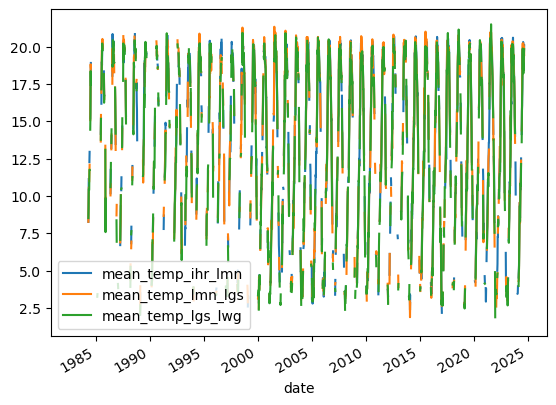

In [134]:
ihr_lwg_chinook_df_weekly.plot(x="date", y=["mean_temp_ihr_lmn", "mean_temp_lmn_lgs", "mean_temp_lgs_lwg"])

In [135]:
ihr_lwg_chinook_df_weekly['ihr_lmn_t_grad'] = ihr_lwg_chinook_df_weekly['mean_temp_ihr_lmn'] - ihr_lwg_chinook_df_weekly['mean_temp_lmn_lgs']
ihr_lwg_chinook_df_weekly['lmn_lgs_t_grad'] = ihr_lwg_chinook_df_weekly['mean_temp_lmn_lgs'] - ihr_lwg_chinook_df_weekly['mean_temp_lgs_lwg']

In [136]:
ihr_lwg_chinook_df_weekly.to_csv("ihr_lwg_chinook_df_weekly.csv", index=False)

In [139]:
ihr_lwg_chinook_df_weekly[["ihr_lmn_delta_ratio"]].dropna().min()

ihr_lmn_delta_ratio   -11.6
dtype: float64

<Axes: xlabel='date'>

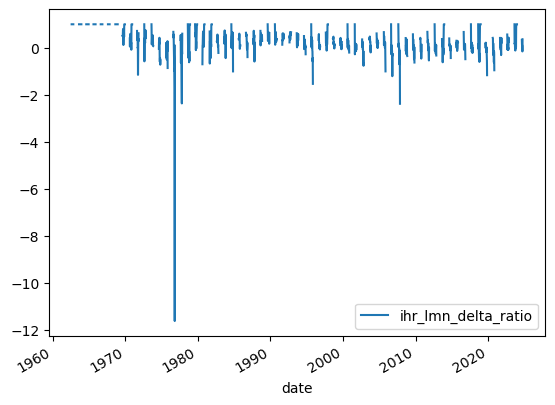

In [138]:
ihr_lwg_chinook_df_weekly.plot(x="date", y=["ihr_lmn_delta_ratio",])

In [143]:
ihr_lwg_chinook_df_weekly.dropna(subset=["ihr_lmn_delta_ratio", "ihr_lmn_t_grad"] ).to_csv("ihr_lmn_nona.csv", index=False)
ihr_lwg_chinook_df_weekly.dropna(subset=["lmn_lgs_delta_ratio", "lmn_lgs_t_grad"] ).to_csv("lmn_lgs_nona.csv", index=False)

## 